# Results analysis and visualization

In [4]:
%run _imports.ipynb

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import seaborn as sns

In [5]:
# Joule standards for figures format:
# - 1 column figre: 112 mm
# - full width of the page: 172 mm
# - max. height figure : 247 mm

fig_length = {1:   4.40944882,    # 1 column
              2:   6.77165354}    # 2 columns
fig_height = 9.72441 # maxium height
fontsize_title = 8
fontsize_label = 7
fontsize_legend = 7
fontsize_axs = 7
spineline_width = 0.5

RM_LIST = (
    "Lithium, brine",
    "Lithium, spodumene",
    "Cobalt",
    "Nickel",
    "Graphite, natural",
    "Graphite, synthetic"
)

rm_titles = {
    "A": "Lithium hydroxide | Brine",
    "B": "Lithium hydroxide | Spodumene",
    "C": "Cobalt sulfate",
    "D": "Nickel sulfate",
    "E": "Graphite | Natural",
    "F": "Graphite | Synthetic"
}

CONTRIBUTORS_LIST = [
    "Electricity consumption",
    "Process heating",
    "Fuels consumption",
    "Reagents consumption",
    "Process emissions",
    "Other"
]

RM_STAGES = [
    "Mining", "Concentration", "Refining", "Total"
]

SG_STAGES = [
    "Calcination", "Graphite crucibles", "Milling", "Graphitization", "Micronization", "Coating", "Total"
]

## Fig 1: Minerals demand and GHG-emissions intensity

In [17]:
# Import IEA mineral demand dataset
total_demand = pd.read_excel(Path(DATA_DIR / "IEA_Minerals demand.xlsx"), sheet_name="Total demand").ffill(axis=0)
ev_demand = pd.read_excel(Path(DATA_DIR / "IEA_Minerals demand.xlsx"), sheet_name="EV demand").ffill(axis=0)

# Extract total mineral demand and EVs mineral demand in 2022 and 2030 NZE scenario
total_demand_2022 = total_demand[(total_demand["Scenario"] == "STEPS") & (total_demand["Year"] == 2022)].reset_index()
total_demand_2030_NZE = total_demand[(total_demand["Scenario"] == "NZE") & (total_demand["Year"] == 2030)].reset_index()

ev_demand_2022 = ev_demand[(ev_demand["Scenario"] == "STEPS") & (ev_demand["Year"] == 2022)].reset_index()
ev_demand_2030_NZE = ev_demand[(ev_demand["Scenario"] == "NZE") & (ev_demand["Year"] == 2030)].reset_index()

# Compute share of EV in total mineral demand
share_ev_demand = ev_demand.iloc[:,2:].div(total_demand.iloc[:,2:]).multiply(100)
share_ev_demand = pd.concat([total_demand.iloc[:,:2], share_ev_demand], axis=1)

# Calculate relative increase in total demand by 2030 in NZE scenario
total_demand_increase_rltv_2030_NZE = total_demand_2030_NZE.iloc[:,3:].div(total_demand_2022.iloc[:,3:], axis=0)
total_demand_increase_rltv_2030_NZE = total_demand_increase_rltv_2030_NZE.T.sort_values(by=0, ascending=False)

# Calculate relative increase in mineral demand by 2030 in NZE scenario due to EVs
total_demand_increase_abs_2030_NZE = total_demand_2030_NZE.iloc[:,3:] - total_demand_2022.iloc[:,3:]
ev_demand_increase_abs_2030_NZE = ev_demand_2030_NZE.iloc[:,3:] - ev_demand_2022.iloc[:,3:]
demand_increase_by_ev = ev_demand_increase_abs_2030_NZE.div(total_demand_increase_abs_2030_NZE).T

# Import GHG emissions intensities from literature
ghg_emissions_intensities_literature = pd.read_excel(Path(DATA_DIR / "IEA_Minerals demand.xlsx"), sheet_name="GHG intensity metals", index_col=0).ffill(axis=0).T

In [18]:
total_demand_increase_rltv_2030_NZE

,0
Lithium,8.587988
Graphite,7.580284
Nickel,7.559324
Neodymium,5.126362
Manganese,4.664881
Silicon,3.233028
Cobalt,3.012196
Copper,2.742675


In [19]:
demand_increase_by_ev

,0
Copper,0.233157
Lithium,0.939795
Cobalt,0.899755
Graphite,0.921012
Nickel,0.697215
Manganese,0.475141
Silicon,0.187328
Neodymium,0.554340


In [20]:
ghg_emissions_intensities_literature

Emission intensity,Low,High
Lithium hydroxide (LiOH),7.300000,15.700000
Graphite,5.440000,42.200000
Nickel sulfate (NiSO$_4$),1.800000,11.100000
Neodymium oxide (Nd$_2$O$_3$),25.000000,25.000000
Manganese sulfate (MnSO$_4$),0.700000,5.400000
Silicon (metallurgical),11.524619,11.524619
Cobalt sulfate (CoSO$_4$),6.900000,35.600000
Copper cathode,4.100000,4.100000


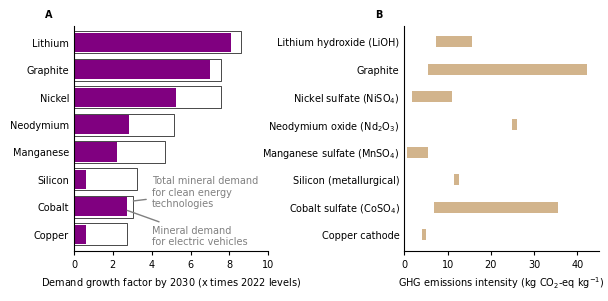

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(fig_length[2], fig_height*0.3))

total_demand_increase_rltv_2030_NZE.plot.barh(ax=axs[0], color="white", edgecolor="black", width=0.80, 
                                              fontsize=fontsize_axs, lw=spineline_width, zorder=2, legend=False)

share_rltv_increase_ev_2030_NZE = total_demand_increase_rltv_2030_NZE.multiply(demand_increase_by_ev)
share_rltv_increase_ev_2030_NZE = share_rltv_increase_ev_2030_NZE.reindex(index=total_demand_increase_rltv_2030_NZE.index)
share_rltv_increase_ev_2030_NZE.plot.barh(ax=axs[0], color="purple", edgecolor="none", width=0.70, 
                                          fontsize=fontsize_axs, lw=spineline_width, zorder=2, legend=False)

range_length = []
for index, df_col in ghg_emissions_intensities_literature.iterrows():
    emissions_range = df_col["High"] - df_col["Low"]
    if emissions_range == 0:
        emissions_range = 1
    range_length.append(emissions_range)

axs[1].barh(ghg_emissions_intensities_literature.index, 
            range_length, 
            left=ghg_emissions_intensities_literature["Low"],
            color="tan", height=0.4)

x_avg = (ghg_emissions_intensities_literature["High"] + ghg_emissions_intensities_literature["Low"])/2

axs[0].set_title("A", loc='left', x=-0.15, fontweight='bold', fontsize=fontsize_axs)
axs[1].set_title("B", loc='left', x=-0.15, fontweight='bold', fontsize=fontsize_axs)

axs[0].set_xlabel('Demand growth factor by 2030 (x times 2022 levels$^{}$)', fontsize=fontsize_label)
axs[1].set_xlabel('GHG emissions intensity (kg CO$_2$-eq kg$^{-1}$)', fontsize=fontsize_label)

for ax in axs:
    ax.invert_yaxis()
    ax.tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
    ax.tick_params(axis='y', which='major', direction='out', length=0, labelsize=fontsize_axs)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
 
axs[0].set_xlim(0, 10)
axs[1].set_xlim(0, 45)

# Anote figure A
axs[0].annotate('Total mineral demand\nfor clean energy\ntechnologies',
             xy=(total_demand_increase_rltv_2030_NZE.loc["Cobalt"].values[0]-0.1, 5.8),
             xytext=(4,6), arrowprops=dict(arrowstyle='-', color='grey'), fontsize=fontsize_axs, color='grey')
axs[0].annotate('Mineral demand\nfor electric vehicles',
             xy=(share_rltv_increase_ev_2030_NZE.loc["Cobalt"].values[0]-0.1, 6.1),
             xytext=(4,7.4), arrowprops=dict(arrowstyle='-', color='grey'), fontsize=fontsize_axs, color='grey')

fig.subplots_adjust(hspace=0.3, wspace=0.7)

#plt.savefig(Path(str(r"..\reports") + '/fig1_ev_minerals_demand_IEA_NZE_2030.jpg'), dpi=600, bbox_inches='tight')
#plt.savefig(Path(str(r"..\reports") + '/Figure 1.pdf'), dpi=600, bbox_inches='tight')

## Fig 2: Breakdown GHG emissions

In [8]:
# Import results
total_ghgs = pd.read_csv(RESULTS_IMPORT_DIR / "fig2_total_ghgs_30-07-2024.csv", index_col=0)
breakdown_ghgs = pd.read_csv(RESULTS_IMPORT_DIR / "fig2_breakdown_ghgs_10-07-2024.csv", index_col=0)

def normalize_breakdown(df_raw, metal):
    df = df_raw.loc[metal]
    df.reset_index(inplace=True)
    df = df.pivot(index='Source', columns='Stage', values='Value')

    df_normalized = df.div(df.values.sum()).multiply(100)
    df_normalized["Total"] = df_normalized.sum(axis=1)

    df_normalized = df_normalized.reindex([CONTRIBUTORS_LIST], axis='index', level=0)
    if metal == "Graphite, synthetic":
        df_normalized = df_normalized[SG_STAGES]
    else:
        df_normalized = df_normalized[RM_STAGES]
    return df_normalized

In [9]:
total_ghgs

,Climate change
Raw material,
"Lithium, brine",7.702184
"Lithium, spodumene",17.237323
Cobalt,14.990897
Nickel,5.479065
"Graphite, natural",10.560489
"Graphite, synthetic",43.871478
"Lithium, brine - carbonate",3.620094
"Lithium, spodumene - carbonate",24.105142


In [10]:
normalize_breakdown(breakdown_ghgs, "Lithium, brine")

Stage,Mining,Concentration,Refining,Total
Electricity consumption,0.074443,0.198464,13.349430,13.622338
Process heating,0.000000,0.119294,42.036686,42.155980
Fuels consumption,1.321337,0.000000,3.953922,5.275259
Reagents consumption,0.000000,4.980183,30.562855,35.543038
Process emissions,0.000000,0.000000,0.000000,0.000000
Other,1.319129,2.084249,0.000008,3.403386


In [11]:
normalize_breakdown(breakdown_ghgs, "Lithium, brine").sum()

Stage
Mining             2.714909
Concentration      7.382190
Refining          89.902901
Total            100.000000
dtype: float64

In [12]:
normalize_breakdown(breakdown_ghgs, "Lithium, brine - carbonate")

Stage,Mining,Concentration,Refining,Total
Electricity consumption,0.150845,0.402149,6.454397,7.007390
Process heating,0.000000,0.241726,47.662446,47.904172
Fuels consumption,2.677431,0.000000,0.000000,2.677431
Reagents consumption,0.000000,10.091368,25.423359,35.514728
Process emissions,0.000000,0.000000,0.000000,0.000000
Other,2.672957,4.223323,0.000000,6.896279


In [13]:
normalize_breakdown(breakdown_ghgs, "Lithium, spodumene")

Stage,Mining,Concentration,Refining,Total
Electricity consumption,0.0,0.339446,19.322196,19.661641
Process heating,0.0,0.482685,57.291520,57.774205
Fuels consumption,0.0,0.096411,0.000000,0.096411
Reagents consumption,0.0,0.000000,16.109801,16.109801
Process emissions,0.0,0.000000,0.000000,0.000000
Other,0.0,4.695595,1.662347,6.357942


In [14]:
normalize_breakdown(breakdown_ghgs, "Lithium, spodumene - carbonate")

Stage,Mining,Concentration,Refining,Total
Electricity consumption,0.0,0.276006,7.105932,7.381938
Process heating,0.0,0.392475,78.034489,78.426964
Fuels consumption,0.0,0.078392,0.000000,0.078392
Reagents consumption,0.0,0.000000,8.925323,8.925323
Process emissions,0.0,0.000000,0.000000,0.000000
Other,0.0,3.818023,1.369359,5.187382


In [15]:
normalize_breakdown(breakdown_ghgs, "Lithium, spodumene").sum()

Stage
Mining             0.000000
Concentration      5.614137
Refining          94.385863
Total            100.000000
dtype: float64

In [16]:
normalize_breakdown(breakdown_ghgs, 'Cobalt')

Stage,Mining,Concentration,Refining,Total
Electricity consumption,0.000000,0.705030,7.617489,8.322519
Process heating,0.000000,0.000000,5.674223,5.674223
Fuels consumption,19.736317,0.000000,0.000000,19.736317
Reagents consumption,0.000000,12.771305,49.177211,61.948517
Process emissions,0.000000,0.000000,0.000000,0.000000
Other,0.000000,3.718308,0.600117,4.318424


In [17]:
normalize_breakdown(breakdown_ghgs, 'Cobalt').sum()

Stage
Mining            19.736317
Concentration     17.194643
Refining          63.069040
Total            100.000000
dtype: float64

In [18]:
normalize_breakdown(breakdown_ghgs, 'Nickel')

Stage,Mining,Concentration,Refining,Total
Electricity consumption,3.667961,6.998083,30.905329,41.571373
Process heating,0.000034,0.672118,17.901315,18.573467
Fuels consumption,1.558119,0.116206,0.651297,2.325622
Reagents consumption,0.000000,0.318185,5.941827,6.260013
Process emissions,0.000000,0.521232,23.153503,23.674735
Other,0.884473,0.458987,6.251330,7.594790


In [19]:
normalize_breakdown(breakdown_ghgs, 'Nickel').sum()

Stage
Mining             6.110588
Concentration      9.084810
Refining          84.804602
Total            100.000000
dtype: float64

In [20]:
normalize_breakdown(breakdown_ghgs, 'Graphite, natural')

Stage,Mining,Concentration,Refining,Total
Electricity consumption,1.904868,11.552541,65.373006,78.830415
Process heating,0.000000,4.798941,0.757702,5.556643
Fuels consumption,2.271641,0.105278,0.040639,2.417558
Reagents consumption,0.000000,0.000000,8.024936,8.024936
Process emissions,0.000000,0.000000,0.590948,0.590948
Other,0.262240,0.937945,3.379316,4.579500


In [21]:
normalize_breakdown(breakdown_ghgs, 'Graphite, natural').sum()

Stage
Mining             4.438749
Concentration     17.394705
Refining          78.166546
Total            100.000000
dtype: float64

In [22]:
normalize_breakdown(breakdown_ghgs, 'Graphite, synthetic')

Stage,Calcination,Graphite crucibles,Milling,Graphitization,Micronization,Coating,Total
Electricity consumption,0.000000,8.153037,6.605775,56.106922,7.006352,0.932705,78.804792
Process heating,0.032430,0.000000,0.210621,0.000000,0.162154,1.331161,1.736365
Fuels consumption,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Reagents consumption,0.373995,1.300832,0.000000,0.000000,0.000000,0.211025,1.885851
Process emissions,5.379631,0.290833,0.000000,2.653204,0.000000,0.156428,8.480097
Other,6.555956,0.000000,0.000000,2.305110,0.000000,0.231829,9.092895


In [23]:
normalize_breakdown(breakdown_ghgs, 'Graphite, synthetic').sum()

Stage
Calcination            12.342011
Graphite crucibles      9.744702
Milling                 6.816396
Graphitization         61.065237
Micronization           7.168506
Coating                 2.863149
Total                 100.000000
dtype: float64

C:\Users\istrateir\AppData\Local\Temp\ipykernel_29476\2098327407.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
C:\Users\istrateir\AppData\Local\Temp\ipykernel_29476\2098327407.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
C:\Users\istrateir\AppData\Local\Temp\ipykernel_29476\2098327407.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
C:\Users\istrateir\AppData\Local\Temp\ipykernel_29476\2098327407.py:58: UserWarning: set_tickl

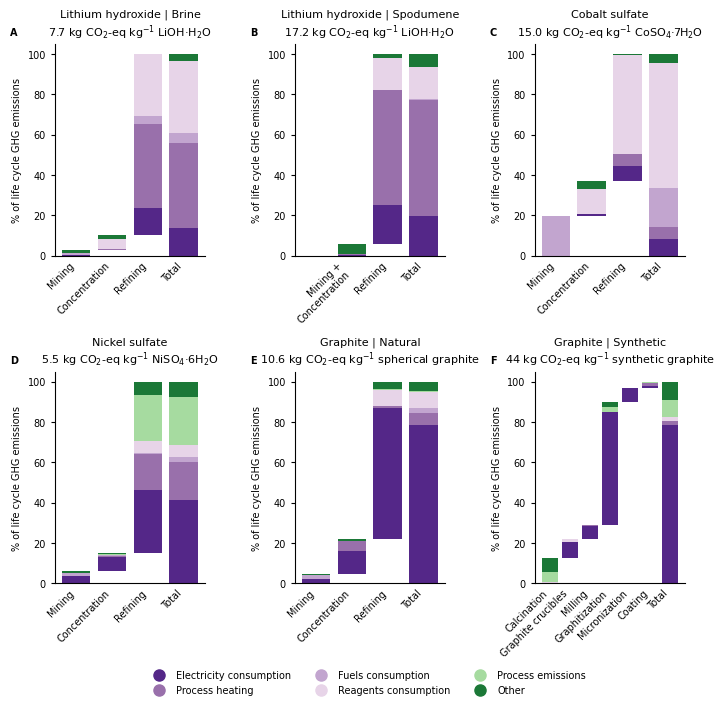

In [28]:
system_color = ['#542788',
                '#9970ab',
                '#c2a5cf',
                '#e7d4e8',
                '#a6dba0',
                '#1b7837']

ghg_units = [
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ CoSO$_4$·7H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ NiSO$_4$·6H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ spherical graphite',
    ' kg CO$_2$-eq kg$^{-1}$ synthetic graphite',
]

width=0.8

fig, axs = plt.subplots(2, 3, figsize=(fig_length[2]*1.2, fig_height*0.72))

rm_count = 0
for row in range(2):
    for col in range(3):
        
        # Set titles 
        axs[row,col].set_title(list(rm_titles.keys())[rm_count], loc='left', x=-0.3, fontweight='bold', fontsize=fontsize_axs)

        rm_name = list(rm_titles.values())[rm_count]
        ghg_intensity_rm = str(round(total_ghgs.iloc[rm_count].values[0])) if rm_name=="Graphite | Synthetic" else \
                              str(round(total_ghgs.iloc[rm_count].values[0], 1))  
        title_with_ghg = rm_name + "\n" + ghg_intensity_rm + ghg_units[rm_count]
        axs[row,col].set_title(title_with_ghg, loc='center', fontsize=fontsize_title)

        # Plot data
        material_data = normalize_breakdown(breakdown_ghgs, RM_LIST[rm_count])

        bottom = 0
        stage_loc = 0
        for stage in material_data.columns:
            cont_count = 0
            if stage == "Total":
                bottom = 0
            else:
                pass
            for contributor in material_data.index:
                axs[row,col].bar(stage, material_data[stage][contributor], bottom=bottom, color=system_color[cont_count],
                                 width=width, lw=spineline_width, zorder=2)

                bottom += material_data[stage][contributor]
                cont_count += 1
            stage_loc += 1

        # Format style
        axs[row,col].set_ylim(0, 105)
        axs[row,col].set_ylabel('% of life cycle GHG emissions', fontsize=fontsize_label)
        axs[row,col].tick_params(axis='y', which='major', direction='out', length=3, labelsize=fontsize_axs)
        axs[row,col].tick_params(axis='x', which='major', direction='out', length=0, labelsize=fontsize_axs)
        axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
        axs[row,col].spines['right'].set_visible(False)
        axs[row,col].spines['top'].set_visible(False)
        
        rm_count += 1
        
axs[0,1].set_xticklabels(["", "Mining +\nConcentration", "Refining", "Total"], rotation=45, ha="right", fontsize=fontsize_axs)

fig.subplots_adjust(wspace=0.6, hspace=0.55)

# LEGEND
handles = []
for i in range(len(CONTRIBUTORS_LIST)):
    patch = Line2D([0], [0], color=system_color[i], label=CONTRIBUTORS_LIST[i], ls='None', marker='o', ms=8)
    handles.append(patch)
axs[1,1].legend(handles=handles, bbox_to_anchor=(2,-0.37), ncol=3, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports") + '/fig2_GHG_emissions_breakdown.jpg'), dpi=600, bbox_inches='tight')
plt.savefig(Path(str(r"..\reports") + '/Figure 2.pdf'), dpi=600, bbox_inches='tight')

### Fig S1: Breakdown GHG emissions lithium carbonate and hydroxide

C:\Users\istrateir\AppData\Local\Temp\ipykernel_17304\826239189.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
C:\Users\istrateir\AppData\Local\Temp\ipykernel_17304\826239189.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
C:\Users\istrateir\AppData\Local\Temp\ipykernel_17304\826239189.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
C:\Users\istrateir\AppData\Local\Temp\ipykernel_17304\826239189.py:72: UserWarning: set_ticklabel

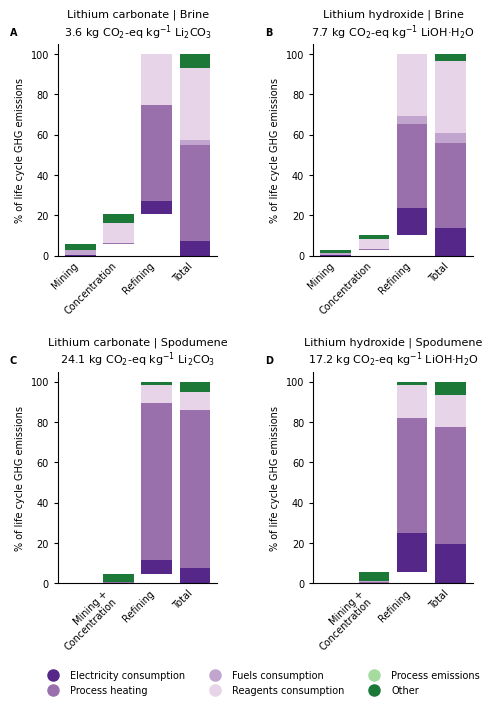

In [448]:
system_color = ['#542788',
                '#9970ab',
                '#c2a5cf',
                '#e7d4e8',
               # '#d9f0d3',
                '#a6dba0',
                '#1b7837']

LITHIUM_ROUTES = [
    "Lithium, brine - carbonate",
    "Lithium, brine",
    "Lithium, spodumene - carbonate",
    "Lithium, spodumene"
]

titles_lithium = [
    "Lithium carbonate | Brine",
    "Lithium hydroxide | Brine",
    "Lithium carbonate | Spodumene",
    "Lithium hydroxide | Spodumene"
]

ghg_units = [
    ' kg CO$_2$-eq kg$^{-1}$ Li$_2$CO$_3$',
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ Li$_2$CO$_3$',
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
]


main_title = ["A", "B", "C", "D"]
width=0.8

metal_count = 0
fig, axs = plt.subplots(2, 2, figsize=(fig_length[1.5], fig_height*0.72))
for row in range(2):
    for col in range(2):
        
        # Set titles 
        axs[row,col].set_title(main_title[metal_count], loc='left', x=-0.3, fontweight='bold', fontsize=fontsize_axs)

        metal_assessed = titles_lithium[metal_count]
        ghg_intensity_metal = str(round(total_ghgs.loc[LITHIUM_ROUTES[metal_count]].values[0])) if metal_assessed=="Graphite | Synthetic" else \
                              str(round(total_ghgs.loc[LITHIUM_ROUTES[metal_count]].values[0], 1))  
        title_with_ghg = metal_assessed + "\n" + ghg_intensity_metal + ghg_units[metal_count]
        axs[row,col].set_title(title_with_ghg, loc='center', fontsize=fontsize_title)

        # Plot data
        material_data = normalize_breakdown(breakdown_ghgs, LITHIUM_ROUTES[metal_count])

        bottom = 0
        stage_loc = 0
        for stage in material_data.columns:
            cont_count = 0
            if stage == "Total":
                bottom = 0
            else:
                pass
            for contributor in material_data.index:
                axs[row,col].bar(stage, material_data[stage][contributor], bottom=bottom, color=system_color[cont_count],
                                 width=width, lw=spineline_width, zorder=2)

                bottom += material_data[stage][contributor]
                cont_count += 1
            stage_loc += 1

        # Format style
        axs[row,col].set_ylim(0, 105)
        axs[row,col].set_ylabel('% of life cycle GHG emissions', fontsize=fontsize_label)
        axs[row,col].tick_params(axis='y', which='major', direction='out', length=3, labelsize=fontsize_axs)
        axs[row,col].tick_params(axis='x', which='major', direction='out', length=0, labelsize=fontsize_axs)
        axs[row,col].set_xticklabels(material_data.columns, rotation=45, ha="right", fontsize=fontsize_axs)
        axs[row,col].spines['right'].set_visible(False)
        axs[row,col].spines['top'].set_visible(False)
        
        metal_count += 1
        
axs[1,0].set_xticklabels(["", "Mining +\nConcentration", "Refining", "Total"], rotation=45, ha="right", fontsize=fontsize_axs)
axs[1,1].set_xticklabels(["", "Mining +\nConcentration", "Refining", "Total"], rotation=45, ha="right", fontsize=fontsize_axs)

fig.subplots_adjust(wspace=0.6, hspace=0.55)

# LEGEND
handles = []
for i in range(len(CONTRIBUTORS_LIST)):
    patch = Line2D([0], [0], color=system_color[i], label=CONTRIBUTORS_LIST[i], ls='None', marker='o', ms=8)
    handles.append(patch)
axs[1,1].legend(handles=handles, bbox_to_anchor=(1.1,-0.37), ncol=3, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

plt.savefig(Path(str(r"..\reports") + '/SI_lithium_GHG_emissions_breakdown.jpg'), dpi=600, bbox_inches='tight')

### Fig S2: Breakdown reagents contribution

In [393]:
breakdown_reagents_ghgs = pd.read_csv(RESULTS_IMPORT_DIR / "ESI_breakdown_reagents_ghgs_12-07-2024.csv", index_col=0)

In [394]:
breakdown_reagents_ghgs

,Stage,Reagent,Value
Metal,,,
"Lithium, spodumene - carbonate",Mining,"neutralising agent, sodium hydroxide-equivalent",0.000000
"Lithium, spodumene - carbonate",Mining,"hydrochloric acid, without water, in 30% solut...",0.000000
"Lithium, spodumene - carbonate",Mining,"soda ash, light",0.000000
"Lithium, spodumene - carbonate",Mining,"quicklime, milled, packed",0.000000
"Lithium, spodumene - carbonate",Mining,sulfuric acid,0.000000
...,...,...,...
Nickel,Refining,naphthalene sulfonic acid,0.000128
Nickel,Refining,"sodium chloride, powder",0.000034
Nickel,Refining,"sodium sulfate, anhydrite",0.000040


In [395]:
cumulative_ghgs_reagents = {}

for metal in RM_LIST:
    df = breakdown_reagents_ghgs.loc[metal].set_index("Reagent")
    df = df.pivot_table(index='Reagent', columns='Stage', values='Value')
    impact_reagents = df.sum().sum()
    reagents_share = impact_reagents / total_ghgs.loc[metal].values[0] * 100
    df["Total"] = df.sum(axis=1)

    print(metal, reagents_share)

    df["Total"] = df["Total"] / total_ghgs.loc[metal].values[0] * 100

    df = df.sort_values("Total")
    cumulative_ghgs_reagents[metal] = {}
    cum_sum = 0
    for index, row in df.iterrows():
        cum_sum += row["Total"]
        cumulative_ghgs_reagents[metal][index] = cum_sum


Lithium, brine 35.54303958722503
Lithium, spodumene 16.109800298914177
Cobalt 61.94851726402787
Nickel 6.260012803975778
Graphite, natural 8.024935644496246
Graphite, synthetic 1.8858513699820147


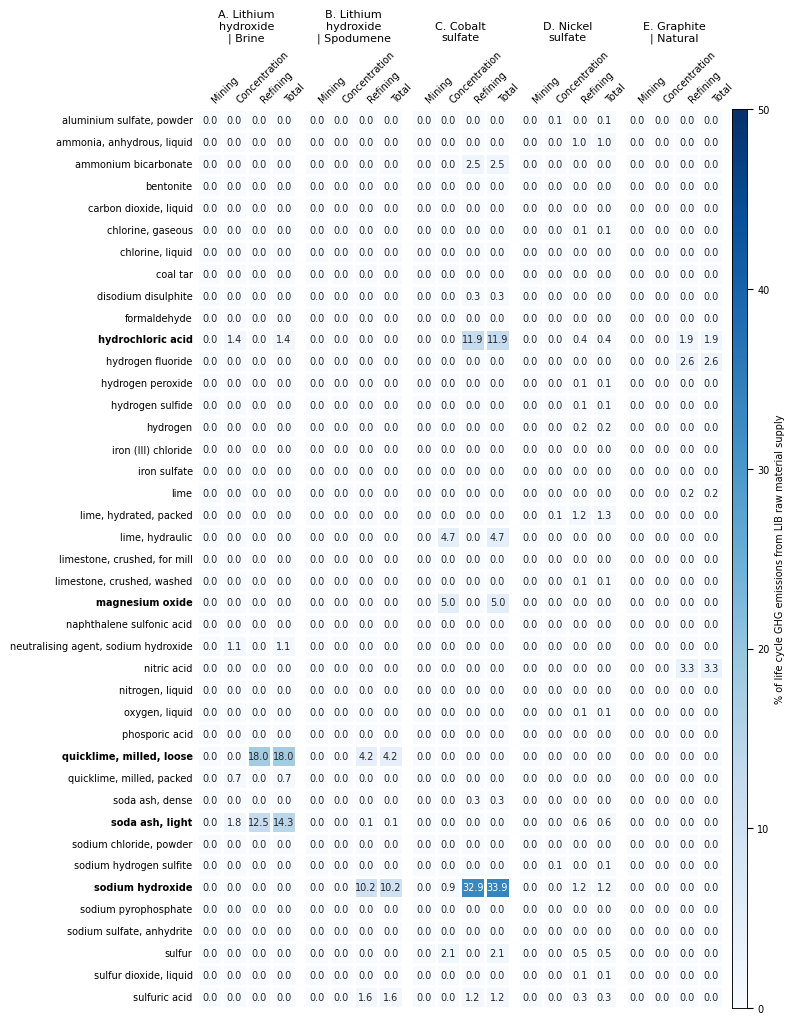

In [397]:
shorten_names = {
    "neutralising agent, sodium hydroxide-equivalent": "neutralising agent, sodium hydroxide",
    "hydrochloric acid, without water, in 30% solution state": "hydrochloric acid",
    "sodium hydroxide, without water, in 50% solution state": "sodium hydroxide",
    "hydrogen peroxide, without water, in 50% solution state": "hydrogen peroxide",
    "nitric acid, without water, in 50% solution state": "nitric acid",
    "phosphoric acid, fertiliser grade, without water, in 70% solution state": "phosporic acid",
    "kerosene": "dearomatized hydrocarbon fluid",
    "iron (III) chloride, without water, in 40% solution state": "iron (III) chloride",
    "hydrogen, gaseous, medium pressure, merchant": "hydrogen",
    "coke": "coke, reducing agent"
}

# Exclude synthetic graphite
RM_LIST_REAG = [i for i in RM_LIST if i!= "Graphite, synthetic"]

titles_space = [
    "A. Lithium\nhydroxide\n| Brine",
    "B. Lithium\nhydroxide\n| Spodumene",
    "C. Cobalt\nsulfate",
    "D. Nickel\nsulfate",
    "E. Graphite\n| Natural",
]

df = breakdown_reagents_ghgs.loc["Lithium, brine"].set_index("Reagent")
df = df.pivot_table(index='Reagent', columns='Stage', values='Value')
reagents_list = df.index

fig, axs = plt.subplot_mosaic([RM_LIST_REAG + ["Legend"]],
                            figsize=(fig_length[2], fig_height*1.2),
                            gridspec_kw={'width_ratios': [0.2] * len(RM_LIST_REAG) + [0.03]})

counter = 0
for rm in RM_LIST_REAG:
    axs[rm].set_title(titles_space[counter], loc='center', fontsize=fontsize_title)

    df = breakdown_reagents_ghgs.loc[rm].set_index("Reagent")
    df = df.pivot_table(index='Reagent', columns='Stage', values='Value')
    df = df / total_ghgs.loc[rm].values[0] * 100
    df["Total"] = df.sum(axis=1)
    df = df.reindex(index=reagents_list)
    df = df.rename(index=shorten_names)
    df = df[RM_STAGES]

   # df_normalized = df_normalized[(df_normalized != 0).any(axis=1)]

    if counter == 0:
        yticklabels=True
    else:
        yticklabels=False

    sns.heatmap(ax=axs[rm], data=df, cmap="Blues", vmin=0, vmax=50, annot=True, fmt='.1f', annot_kws={"size": 7}, 
                xticklabels=True, yticklabels=yticklabels, linewidths=0.8, linecolor='white', cbar=True, cbar_ax=axs['Legend'])
    axs[rm].set_ylabel("")
    axs[rm].set_xlabel("")

    if counter == 0:
        for lab, annot in zip(axs[rm].get_yticklabels(), axs[rm].texts):
            text = lab.get_text()
            if text in ["soda ash, light", "kerosene", "sodium hydroxide",
                        "quicklime, milled, loose", "magnesium oxide",
                    
                        "hydrochloric acid"]:
                # set the properties of the ticklabel
                lab.set_weight('bold')

    counter += 1
    
for col in RM_LIST_REAG:
    axs[col].set_xticklabels(df.columns, rotation = 45, ha="left", fontsize=fontsize_axs)
    axs[col].xaxis.tick_top()
    axs[col].tick_params(axis='x', which='major', direction='in', length=0, labelsize=fontsize_axs)
    axs[col].tick_params(axis='y', which='major', direction='in', length=0, labelsize=fontsize_axs)

    
for spine in axs["Legend"].spines.values():
    spine.set(visible=True, lw=spineline_width, edgecolor="black")
axs["Legend"].tick_params(axis='y', which='major', direction='out', length=4, labelsize=fontsize_axs)
axs['Legend'].set_ylabel('% of life cycle GHG emissions from LIB raw material supply', fontsize=fontsize_label)

fig.subplots_adjust(wspace=0.1)

plt.savefig(Path(str(r"..\reports") + '/SI_reagents_emissions_breakdown.jpg'), dpi=600, bbox_inches='tight')

## Fig 4: Mitigation potential

In [6]:
impacts_mitigation_strategies = pd.read_csv(RESULTS_IMPORT_DIR / "fig4_impacts_decarbonization_31-07-2024.csv", index_col=0)

strategies_name = {
    "BAU": "Current situation",
    "ONSITE_ELEC": "Decarbonization of on-site electricity consumption",
    "ENERGY_EFF": "Improvements in energy efficiency",
    "PROCESS_HEAT": "Decarbonization of process heat",
    "CHEMICALS_DECARB": "Decarbonization of the chemical industry",
    "GLOBAL_ELEC": "Decarbonization of electricity consumption elsewhere",
    "MIT_GAP": "Mitigation gap"
}

In [7]:
actual_mitigation_potential = impacts_mitigation_strategies[impacts_mitigation_strategies["Impact category"] == "Climate change"].drop(["Impact category"], axis=1)
actual_mitigation_potential

,BAU,ONSITE_ELEC,ENERGY_EFF,PROCESS_HEAT,CHEMICALS_DECARB,GLOBAL_ELEC
Raw material,,,,,,
"Lithium, brine",7.702184,6.712789,6.527136,3.555470,2.872008,2.594067
"Lithium, spodumene",17.237323,14.052097,13.538849,6.976248,5.304045,3.921047
Cobalt,14.990897,13.938217,13.698377,13.287720,8.230893,7.021350
Nickel,5.479065,3.302212,3.246286,2.709291,2.499246,2.231801
"Graphite, natural",10.560489,2.599045,2.528060,2.161193,1.829799,1.465916
"Graphite, synthetic",43.871478,10.807973,10.649952,10.331841,10.109708,9.133767


In [8]:
mitigation_normalized = actual_mitigation_potential.div(actual_mitigation_potential["BAU"], axis=0).multiply(100)
mitigation_normalized

,BAU,ONSITE_ELEC,ENERGY_EFF,PROCESS_HEAT,CHEMICALS_DECARB,GLOBAL_ELEC
Raw material,,,,,,
"Lithium, brine",100.0,87.154359,84.743962,46.161843,37.288226,33.679630
"Lithium, spodumene",100.0,81.521340,78.543806,40.471763,30.770701,22.747426
Cobalt,100.0,92.977870,91.377966,88.638590,54.905939,46.837424
Nickel,100.0,60.269625,59.248902,49.448050,45.614461,40.733241
"Graphite, natural",100.0,24.611029,23.938858,20.464894,17.326836,13.881136
"Graphite, synthetic",100.0,24.635533,24.275343,23.550246,23.043919,20.819375


In [9]:
ghgs_times_reduction = 1 / actual_mitigation_potential.div(actual_mitigation_potential["BAU"], axis=0)
ghgs_times_reduction

,BAU,ONSITE_ELEC,ENERGY_EFF,PROCESS_HEAT,CHEMICALS_DECARB,GLOBAL_ELEC
Raw material,,,,,,
"Lithium, brine",1.0,1.147390,1.180025,2.166291,2.681812,2.969154
"Lithium, spodumene",1.0,1.226673,1.273175,2.470859,3.249845,4.396102
Cobalt,1.0,1.075525,1.094356,1.128177,1.821297,2.135045
Nickel,1.0,1.659211,1.687795,2.022324,2.192287,2.454997
"Graphite, natural",1.0,4.063219,4.177309,4.886417,5.771394,7.204021
"Graphite, synthetic",1.0,4.059177,4.119406,4.246240,4.339540,4.803218


In [10]:
mitigation_potential = mitigation_normalized["BAU"] - mitigation_normalized["GLOBAL_ELEC"]
mitigation_potential

Raw material
Lithium, brine         66.320370
Lithium, spodumene     77.252574
Cobalt                 53.162576
Nickel                 59.266759
Graphite, natural      86.118864
Graphite, synthetic    79.180625
dtype: float64

In [11]:
mitigation_gap = mitigation_normalized.iloc[:,-1]
mitigation_gap

Raw material
Lithium, brine         33.679630
Lithium, spodumene     22.747426
Cobalt                 46.837424
Nickel                 40.733241
Graphite, natural      13.881136
Graphite, synthetic    20.819375
Name: GLOBAL_ELEC, dtype: float64

In [12]:
print(mitigation_normalized["BAU"] - mitigation_normalized["ONSITE_ELEC"])
print(mitigation_normalized["ONSITE_ELEC"] - mitigation_normalized["ENERGY_EFF"])
print(mitigation_normalized["ENERGY_EFF"] - mitigation_normalized["PROCESS_HEAT"])
print(mitigation_normalized["PROCESS_HEAT"] - mitigation_normalized["CHEMICALS_DECARB"])

Raw material
Lithium, brine         12.845641
Lithium, spodumene     18.478660
Cobalt                  7.022130
Nickel                 39.730375
Graphite, natural      75.388971
Graphite, synthetic    75.364467
dtype: float64
Raw material
Lithium, brine         2.410397
Lithium, spodumene     2.977534
Cobalt                 1.599904
Nickel                 1.020723
Graphite, natural      0.672171
Graphite, synthetic    0.360190
dtype: float64
Raw material
Lithium, brine         38.582119
Lithium, spodumene     38.072043
Cobalt                  2.739376
Nickel                  9.800852
Graphite, natural       3.473963
Graphite, synthetic     0.725097
dtype: float64
Raw material
Lithium, brine          8.873617
Lithium, spodumene      9.701062
Cobalt                 33.732651
Nickel                  3.833589
Graphite, natural       3.138059
Graphite, synthetic     0.506327
dtype: float64


In [13]:
MonteCarlo_results_iter = pd.read_csv(RESULTS_IMPORT_DIR / "fig4_MonteCarlo_results_iterations_30-08-2024.csv", index_col=0)
MonteCarlo_results_iter = MonteCarlo_results_iter.reset_index()
MonteCarlo_results_iter.set_index(["Scenario", "Raw material", "Impact category"], inplace=True)

In [14]:
# Calculate statistics results
MonteCarlo_results_stats = MonteCarlo_results_iter.T.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
MonteCarlo_results_stats

count       mean        std  \
Scenario    Raw material        Impact category                                 
BAU         Lithium, brine      Climate change   1000.0   8.568098   0.956560   
            Lithium, spodumene  Climate change   1000.0  18.619004   2.162174   
            Cobalt              Climate change   1000.0  17.750362   2.961550   
            Nickel              Climate change   1000.0   6.067123   1.097785   
            Graphite, natural   Climate change   1000.0  11.310876   0.793719   
            Graphite, synthetic Climate change   1000.0  49.238045  12.163418   
GLOBAL_ELEC Lithium, brine      Climate change   1000.0   2.968620   0.528055   
            Lithium, spodumene  Climate change   1000.0   4.990468   0.583457   
            Cobalt              Climate change   1000.0   8.911143   2.348213   
            Nickel              Climate change   1000.0   2.507980   0.597844   
            Graphite, natural   Climate change   1000.0   1.735281   0.130564   
            Graphite, synthetic Climate change   1000.0  10.646919   3.066860   

                                                       min         5%  \
Scenario    Raw material        Impact category                         
BAU         Lithium, brine      Climate change    6.112080   7.179485   
            Lithium, spodumene  Climate change   13.761482  15.537073   
            Cobalt              Climate change   11.340646  13.697790   
            Nickel              Climate change    3.706990   4.493077   
            Graphite, natural   Climate change    9.015066  10.190988   
            Graphite, synthetic Climate change   23.533997  32.118778   
GLOBAL_ELEC Lithium, brine      Climate change    1.630628   2.192068   
            Lithium, spodumene  Climate change    3.599690   4.085819   
            Cobalt              Climate change    4.693523   5.978799   
            Nickel              Climate change    1.197019   1.679642   
            Graphite, natural   Climate change    1.418754   1.534872   
            Graphite, synthetic Climate change    4.785036   6.614178   

                                                       25%        50%  \
Scenario    Raw material        Impact category                         
BAU         Lithium, brine      Climate change    7.903209   8.473322   
            Lithium, spodumene  Climate change   16.971527  18.424001   
            Cobalt              Climate change   15.736507  17.403845   
            Nickel              Climate change    5.257842   5.935178   
            Graphite, natural   Climate change   10.778118  11.221310   
            Graphite, synthetic Climate change   40.427747  47.371835   
GLOBAL_ELEC Lithium, brine      Climate change    2.591757   2.925328   
            Lithium, spodumene  Climate change    4.622704   4.936927   
            Cobalt              Climate change    7.353757   8.385944   
            Nickel              Climate change    2.102822   2.420021   
            Graphite, natural   Climate change    1.644873   1.728101   
            Graphite, synthetic Climate change    8.445108  10.202710   

                                                       75%        95%  \
Scenario    Raw material        Impact category                         
BAU         Lithium, brine      Climate change    9.137561  10.286362   
            Lithium, spodumene  Climate change   19.944823  22.503978   
            Cobalt              Climate change   19.324436  23.036557   
            Nickel              Climate change    6.766727   8.033710   
            Graphite, natural   Climate change   11.756407  12.733043   
            Graphite, synthetic Climate change   57.249717  71.636203   
GLOBAL_ELEC Lithium, brine      Climate change    3.270388   3.906217   
            Lithium, spodumene  Climate change    5.350960   6.037162   
            Cobalt              Climate change   10.057575  12.889883   
            Nickel              Climate change    2.846905   3.545

In [15]:
# Calculate statistics results
MonteCarlo_results_stats = MonteCarlo_results_iter.T.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
MonteCarlo_results_stats

count       mean        std  \
Scenario    Raw material        Impact category                                 
BAU         Lithium, brine      Climate change   1000.0   8.568098   0.956560   
            Lithium, spodumene  Climate change   1000.0  18.619004   2.162174   
            Cobalt              Climate change   1000.0  17.750362   2.961550   
            Nickel              Climate change   1000.0   6.067123   1.097785   
            Graphite, natural   Climate change   1000.0  11.310876   0.793719   
            Graphite, synthetic Climate change   1000.0  49.238045  12.163418   
GLOBAL_ELEC Lithium, brine      Climate change   1000.0   2.968620   0.528055   
            Lithium, spodumene  Climate change   1000.0   4.990468   0.583457   
            Cobalt              Climate change   1000.0   8.911143   2.348213   
            Nickel              Climate change   1000.0   2.507980   0.597844   
            Graphite, natural   Climate change   1000.0   1.735281   0.130564   
            Graphite, synthetic Climate change   1000.0  10.646919   3.066860   

                                                       min         5%  \
Scenario    Raw material        Impact category                         
BAU         Lithium, brine      Climate change    6.112080   7.179485   
            Lithium, spodumene  Climate change   13.761482  15.537073   
            Cobalt              Climate change   11.340646  13.697790   
            Nickel              Climate change    3.706990   4.493077   
            Graphite, natural   Climate change    9.015066  10.190988   
            Graphite, synthetic Climate change   23.533997  32.118778   
GLOBAL_ELEC Lithium, brine      Climate change    1.630628   2.192068   
            Lithium, spodumene  Climate change    3.599690   4.085819   
            Cobalt              Climate change    4.693523   5.978799   
            Nickel              Climate change    1.197019   1.679642   
            Graphite, natural   Climate change    1.418754   1.534872   
            Graphite, synthetic Climate change    4.785036   6.614178   

                                                       25%        50%  \
Scenario    Raw material        Impact category                         
BAU         Lithium, brine      Climate change    7.903209   8.473322   
            Lithium, spodumene  Climate change   16.971527  18.424001   
            Cobalt              Climate change   15.736507  17.403845   
            Nickel              Climate change    5.257842   5.935178   
            Graphite, natural   Climate change   10.778118  11.221310   
            Graphite, synthetic Climate change   40.427747  47.371835   
GLOBAL_ELEC Lithium, brine      Climate change    2.591757   2.925328   
            Lithium, spodumene  Climate change    4.622704   4.936927   
            Cobalt              Climate change    7.353757   8.385944   
            Nickel              Climate change    2.102822   2.420021   
            Graphite, natural   Climate change    1.644873   1.728101   
            Graphite, synthetic Climate change    8.445108  10.202710   

                                                       75%        95%  \
Scenario    Raw material        Impact category                         
BAU         Lithium, brine      Climate change    9.137561  10.286362   
            Lithium, spodumene  Climate change   19.944823  22.503978   
            Cobalt              Climate change   19.324436  23.036557   
            Nickel              Climate change    6.766727   8.033710   
            Graphite, natural   Climate change   11.756407  12.733043   
            Graphite, synthetic Climate change   57.249717  71.636203   
GLOBAL_ELEC Lithium, brine      Climate change    3.270388   3.906217   
            Lithium, spodumene  Climate change    5.350960   6.037162   
            Cobalt              Climate change   10.057575  12.889883   
            Nickel              Climate change    2.846905   3.545

In [16]:
# Calculate stohastic mitigation potential
MonteCarlo_mitigation_potential = (1 - (MonteCarlo_results_iter.loc["GLOBAL_ELEC"] / MonteCarlo_results_iter.loc["BAU"]))*100
MonteCarlo_mitigation_potential_stats = MonteCarlo_mitigation_potential.T.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T

In [17]:
MonteCarlo_mitigation_potential_stats

,,count,mean,std,min,5%,25%,50%,75%,95%,max
Raw material,Impact category,,,,,,,,,,
"Lithium, brine",Climate change,1000.0,64.909631,7.432530,27.859286,51.596084,60.369161,65.371355,70.207253,75.701665,82.565034
"Lithium, spodumene",Climate change,1000.0,72.840273,4.466075,55.914872,64.788180,70.116517,73.151344,75.886251,79.622726,82.623802
Cobalt,Climate change,1000.0,48.455260,16.280841,-62.619134,19.939678,40.804649,51.301324,59.277137,68.146099,79.519322
Nickel,Climate change,1000.0,57.373642,12.779498,-20.315950,34.180632,50.807915,59.348643,66.215793,74.976561,80.730269
"Graphite, natural",Climate change,1000.0,84.584224,1.574472,79.575210,81.678462,83.653716,84.613244,85.641164,87.057753,88.631019
"Graphite, synthetic",Climate change,1000.0,77.036217,9.004810,31.235681,59.626309,72.869021,78.919429,83.257664,88.095201,93.426414


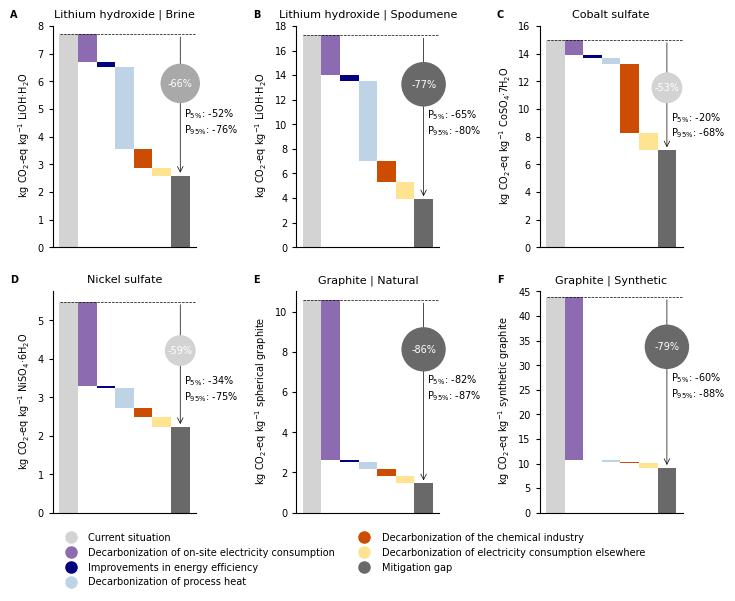

In [42]:
strategy_color = ["lightgrey", "#8c6bb1", "navy", "#bfd3e6", "#cc4c02", "#fee391", "dimgrey"]

ghg_units = [
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ CoSO$_4$·7H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ NiSO$_4$·6H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ spherical graphite',
    ' kg CO$_2$-eq kg$^{-1}$ synthetic graphite',
]

y_lims = [
    8, 18, 16, 5.75, 11, 45
]

width=1

fig, axs = plt.subplots(2, 3, figsize=(fig_length[2]*1.2, fig_height*0.65))

rm_count = 0
for row in range(2):
    for col in range(3):
        rm_name = actual_mitigation_potential.index[rm_count]

        # Set titles 
        main_title = list(rm_titles.keys())[rm_count]
        axs[row,col].set_title(main_title, loc='left', x=-0.3, fontweight='bold', fontsize=fontsize_axs)
        axs[row,col].set_title(rm_titles[main_title], loc='center', fontsize=fontsize_title)

        # Plot bars
        count_strategy = 0
        for scenario in actual_mitigation_potential.columns:
            if count_strategy == 0:
                axs[row, col].bar(count_strategy, actual_mitigation_potential.loc[rm_name][scenario], color=strategy_color[count_strategy], width=width, lw=spineline_width, zorder=2)
            else:
                previous = actual_mitigation_potential.loc[rm_name].iloc[count_strategy-1]
                axs[row, col].bar(count_strategy, previous, color=strategy_color[count_strategy], width=width, lw=spineline_width, zorder=2)

            if count_strategy > 0:
                axs[row, col].bar(count_strategy, actual_mitigation_potential.loc[rm_name][scenario], color="white", width=width, lw=spineline_width, zorder=2)

            count_strategy += 1

        axs[row, col].bar(count_strategy, actual_mitigation_potential.loc[rm_name]["GLOBAL_ELEC"], color=strategy_color[count_strategy], width=width, lw=spineline_width, zorder=2)
        
        
        # Annote mitigation potential
        axs[row, col].axhline(xmin=0.05, xmax=1, y=actual_mitigation_potential.loc[rm_name]["BAU"], ls="--", color="black", lw=0.5)
        axs[row, col].annotate('', xy=(count_strategy, (actual_mitigation_potential.loc[rm_name]["GLOBAL_ELEC"])),
                               xytext=(count_strategy, actual_mitigation_potential.loc[rm_name]["BAU"]),
                              arrowprops=dict(arrowstyle='->', color='black', linewidth=0.5), annotation_clip=False)
        loc_bubble = (actual_mitigation_potential.loc[rm_name]["BAU"])/1.3
        axs[row, col].text(count_strategy, loc_bubble, "-" + str(round(mitigation_potential[rm_name])) + '%', ha="center", color="white", va="center", rotation=0, size=fontsize_axs, 
                                    bbox=dict(boxstyle="circle", lw=0.5, ls="None",
                                             fc="lightgrey" if mitigation_potential[rm_name] < 60 else 
                                             ("darkgray" if 60 <=  mitigation_potential[rm_name] < 70 else "dimgrey"),
                                             pad=0.3 if  mitigation_potential[rm_name] < 60 else 
                                             (0.75 if 60 <=  mitigation_potential[rm_name] < 70 else 1)))

        # Note 5th-95th percentiles from the Monte Carlo simulation
        percent_low = MonteCarlo_mitigation_potential_stats.loc[rm_name]["5%"].values[0]
        percent_high = MonteCarlo_mitigation_potential_stats.loc[rm_name]["95%"].values[0]
        percent_range = r"P$_{5\%}$: " + str(round(-percent_low)) + "%" + "\n" + r"P$_{95\%}$: " + str(round(-percent_high)) + "%"
        loc_percent = (actual_mitigation_potential.loc[rm_name]["BAU"])/1.7
        axs[row, col].text(count_strategy+0.2, loc_percent, percent_range, ha="left", color="black", va="center", rotation=0, size=fontsize_axs)


        axs[row, col].set_ylabel(ghg_units[rm_count], fontsize=fontsize_label)
        axs[row, col].tick_params(axis='y', which='major', direction='out', length=3, labelsize=fontsize_axs)
        axs[row, col].tick_params(axis='x', which='major', direction='out', length=0, labelsize=fontsize_axs)
        axs[row, col].set_ylim(0, y_lims[rm_count])
        axs[row, col].set_xticks([])
        
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['top'].set_visible(False)

        rm_count += 1

# LEGEND
patches = []
count_sc = 0
for sc in strategies_name:
    patch = Line2D([0], [0], color=strategy_color[count_sc], label=strategies_name[sc], ls='None', marker='o', ms=8)
    patches.append(patch)
    count_sc += 1

axs[1,1].legend(handles=patches, bbox_to_anchor=(2.5,-0.05), ncol=2, frameon=False, edgecolor='black',  facecolor='White', fontsize=fontsize_legend)

fig.subplots_adjust(wspace=0.7, hspace=0.2)

plt.savefig(Path(str(r"..\reports") + '/fig4_actual_mitigation_potential.jpg'), dpi=600, bbox_inches='tight')
plt.savefig(Path(str(r"..\reports") + '/Figure 4.pdf'), dpi=600, bbox_inches='tight')

### Fig S3: Monte Carlo analysis results

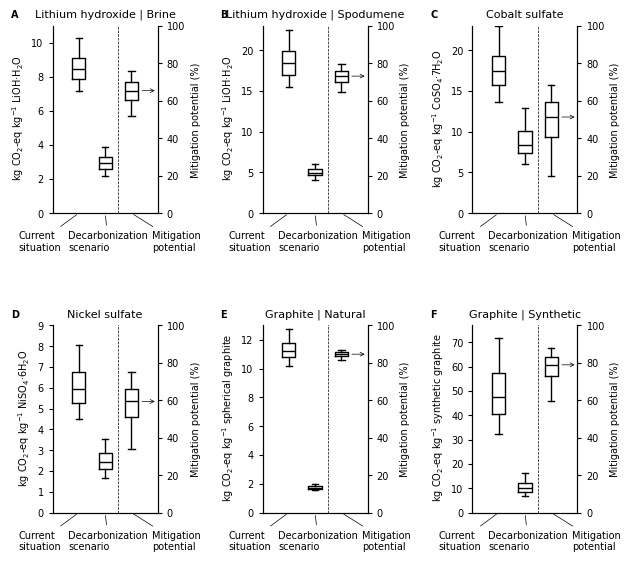

In [19]:
ghg_units = [
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ LiOH·H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ CoSO$_4$·7H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ NiSO$_4$·6H$_2$O',
    ' kg CO$_2$-eq kg$^{-1}$ spherical graphite',
    ' kg CO$_2$-eq kg$^{-1}$ synthetic graphite',
]

y_lims = [
    11, 23, 23, 9, 13, 77
]

fig, axs = plt.subplots(2, 3, figsize=(fig_length[2]*1, fig_height*0.65))

width=0.5
boxlinewidth=1
box_color = 'black'
boxprops = dict(linestyle='-', linewidth=boxlinewidth, color=box_color)
flierprops = dict(marker='o', linewidth=boxlinewidth, markerfacecolor=box_color, markersize=12, linestyle='none')
medianprops = dict(linestyle='-', linewidth=boxlinewidth, color=box_color)
meanpointprops = dict(marker='D', linewidth=boxlinewidth, markeredgecolor='grey', markerfacecolor=box_color)
meanlineprops = dict(linestyle='--', linewidth=boxlinewidth, color=box_color)
whiskerprops = dict(color=box_color, linewidth=boxlinewidth, )
capprops = dict(color=box_color, linewidth=boxlinewidth, )

def extract_stats(row):
    return {
        'whislo': row['5%'],
        'q1': row['25%'],
        'med': row['50%'],
        'q3': row['75%'],
        'whishi': row['95%'],
        'fliers': []
    }

rm_count = 0
for row in range(2):
    for col in range(3):
        rm_name = RM_LIST[rm_count]

        # Set titles 
        main_title = list(rm_titles.keys())[rm_count]
        axs[row,col].set_title(main_title, loc='left', x=-0.4, fontweight='bold', fontsize=fontsize_axs)
        axs[row,col].set_title(rm_titles[main_title], loc='center', fontsize=fontsize_title)

       # Plot boxplots
        mc_stats = [extract_stats(MonteCarlo_results_stats.loc[:, rm_name, "Climate change"].loc['BAU']), 
                    extract_stats(MonteCarlo_results_stats.loc[:, rm_name, "Climate change"].loc['GLOBAL_ELEC'])]
        axs[row,col].bxp(mc_stats, positions=[1,2],
                        showfliers=False, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, 
                        medianprops=medianprops)
        
        # Plot boxplots for mitigation potential
        axs2 = axs[row,col].twinx()
        axs[row, col].axvline(ymin=0, ymax=100, x=2.5, ls="--", color="black", lw=0.5)

        mc_stats_potential = [extract_stats(MonteCarlo_mitigation_potential_stats.loc[rm_name, "Climate change"])]
        axs2.bxp(mc_stats_potential, positions=[3],
                     showfliers=False, widths=width, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, 
                     medianprops=medianprops)       

        axs[row, col].set_ylabel(ghg_units[rm_count], fontsize=fontsize_label)
        axs2.set_ylabel("Mitigation potential (%)", fontsize=fontsize_label)
        axs2.annotate('', xy=(4, mc_stats_potential[0]["med"]),
                               xytext=(3.3, mc_stats_potential[0]["med"]),
                              arrowprops=dict(arrowstyle='->', color='black', linewidth=0.5), fontsize=fontsize_axs, annotation_clip=False)
        

        axs[row, col].tick_params(axis='y', which='major', direction='out', length=3, labelsize=fontsize_axs)
        axs[row, col].tick_params(axis='x', which='major', direction='out', length=0, labelsize=fontsize_axs)
        axs2.tick_params(axis='y', which='major', direction='out', length=3, labelsize=fontsize_axs)
        axs2.tick_params(axis='x', which='major', direction='out', length=0, labelsize=fontsize_axs)

        axs[row, col].set_xlim(0, 4)
        axs[row, col].set_ylim(0, y_lims[rm_count])
        axs2.set_ylim(0, 100)

      #  axs[row, col].set_xticklabels(["Current\nsituation", "Mitigation\ngap", "Mitigaiton\npotential"],  rotation=0, ha="center", fontsize=fontsize_axs)
        
        axs[row, col].set_xticklabels([],  rotation=0, ha="center", fontsize=fontsize_axs)
        axs[row, col].annotate('Current\nsituation', xy=(1, 0),
                               xytext=(-1.3, -(y_lims[rm_count]/5)),
                              arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5), fontsize=fontsize_axs, annotation_clip=False)
        axs[row, col].annotate('Decarbonization\nscenario', xy=(2, 0),
                               xytext=(0.6, -(y_lims[rm_count]/5)),
                              arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5), fontsize=fontsize_axs, annotation_clip=False)
        axs[row, col].annotate('Mitigation\npotential', xy=(3, 0),
                               xytext=(3.8, -(y_lims[rm_count]/5)),
                              arrowprops=dict(arrowstyle='-', color='black', linewidth=0.5), fontsize=fontsize_axs, annotation_clip=False)
                
        axs[row, col].spines['top'].set_visible(False)
        axs2.spines['top'].set_visible(False)

        rm_count += 1


fig.subplots_adjust(wspace=1, hspace=0.6)

plt.savefig(Path(str(r"..\reports") + '/SI_MonteCarlo_mitigation_potential.jpg'), dpi=600, bbox_inches='tight')

### Fig S4: Trade-offs from decarbonization scenario

In [62]:
impacts_mitigation_strategies

,Impact category,BAU,ONSITE_ELEC,ENERGY_EFF,PROCESS_HEAT,CHEMICALS_DECARB,GLOBAL_ELEC
Raw material,,,,,,,
"Lithium, brine",Particulate matter formation,3.637055e-07,3.212228e-07,3.160676e-07,3.101449e-07,2.285760e-07,2.180865e-07
"Lithium, brine",Water use,2.078269e+00,2.021847e+00,2.017473e+00,1.997869e+00,2.005457e+00,1.916270e+00
"Lithium, brine",Photochemical oxidant formation,2.572578e-02,2.075441e-02,2.017660e-02,1.428941e-02,1.254115e-02,1.174633e-02
"Lithium, brine",Acidification,3.202461e-02,2.480268e-02,2.449185e-02,2.313760e-02,1.933575e-02,1.806129e-02
"Lithium, brine",Climate change,7.702184e+00,6.712789e+00,6.527136e+00,3.555470e+00,2.872008e+00,2.594067e+00
...,...,...,...,...,...,...,...
"Graphite, synthetic","Material resources, minerals/metals",2.646983e-05,1.393964e-04,1.313658e-04,1.685381e-04,1.731739e-04,1.778814e-04
"Graphite, synthetic",Ozone depletion,2.880613e-07,2.381347e-07,2.359550e-07,2.274755e-07,2.259150e-07,2.200301e-07
"Graphite, synthetic",Particulate matter formation,3.061398e-06,6.646087e-07,6.527492e-07,6.887044e-07,6.801713e-07,6.386021e-07


In [63]:
EF_METHODS = {
                'Climate change':                      ('IPCC 2021', 'climate change: including SLCFs', 'global warming potential (GWP100)'),
                'Acidification':                       ('EF v3.1', 'acidification', 'accumulated exceedance (AE)'),
                'Eutrophication, freshwater':          ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'),
                'Eutrophication, marine':              ('EF v3.1', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'),
                'Eutrophication, terrestrial':         ('EF v3.1', 'eutrophication: terrestrial', 'accumulated exceedance (AE)'),
                'Photochemical oxidant formation':     ('EF v3.1', 'photochemical oxidant formation: human health', 'tropospheric ozone concentration increase'),
                'Particulate matter formation':        ('EF v3.1', 'particulate matter formation', 'impact on human health'),
                'Ozone depletion':                     ('EF v3.1', 'ozone depletion', 'ozone depletion potential (ODP)'),
                'Ecotoxicity, freshwater':             ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'),
                'Human toxicity, carcinogenic':        ('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)'),
                'Human toxicity, non-carcinogenic':    ('EF v3.1', 'human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh)'),
                'Ionising radiation':                  ('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235'), 
                'Energy resources, non-renewable':     ('EF v3.1', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'),
                'Material resources, minerals/metals': ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'),
                'Land use':                            ('EF v3.1', 'land use', 'soil quality index'),
                'Water use':                           ('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)')
               }

def calculate_relative_diff_impacts(rm_name):
    
    impacts_rm = impacts_mitigation_strategies.loc[rm_name]

    impacts_rm["Relative diff RM"] = (impacts_rm["CHEMICALS_DECARB"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]
    impacts_rm["Relative diff GLO"] = (impacts_rm["GLOBAL_ELEC"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]

    impacts_rm.reset_index(inplace=True)
    impacts_rm.set_index("Impact category", inplace=True)
    impacts_rm = impacts_rm.reindex(EF_METHODS.keys())
    return impacts_rm

In [67]:
calculate_relative_diff_impacts("Lithium, spodumene")

C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\2923109238.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_rm["Relative diff RM"] = (impacts_rm["CHEMICALS_DECARB"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]
C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\2923109238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_rm["Relative diff GLO"] = (impacts_rm["GLOBAL_ELEC"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]


,Raw material,BAU,ONSITE_ELEC,ENERGY_EFF,PROCESS_HEAT,CHEMICALS_DECARB,GLOBAL_ELEC,Relative diff RM,Relative diff GLO
Impact category,,,,,,,,,
Climate change,"Lithium, spodumene",1.723732e+01,1.405210e+01,1.353885e+01,6.976248e+00,5.304045e+00,3.921047e+00,-69.229299,-77.252574
Acidification,"Lithium, spodumene",1.468851e-01,1.307850e-01,1.265505e-01,7.874866e-02,7.196497e-02,6.555258e-02,-51.005942,-55.371526
"Eutrophication, freshwater","Lithium, spodumene",4.915868e-03,4.417355e-03,4.261015e-03,3.426763e-03,2.875045e-03,2.285178e-03,-41.515014,-53.514253
"Eutrophication, marine","Lithium, spodumene",2.270913e-02,1.917011e-02,1.867093e-02,1.367601e-02,1.221088e-02,1.084289e-02,-46.229183,-52.253143
"Eutrophication, terrestrial","Lithium, spodumene",2.414510e-01,2.045417e-01,1.992833e-01,1.632055e-01,1.495254e-01,1.363103e-01,-38.072146,-43.545370
Photochemical oxidant formation,"Lithium, spodumene",6.939057e-02,5.949954e-02,5.795817e-02,4.432158e-02,3.985255e-02,3.586002e-02,-42.567775,-48.321481
Particulate matter formation,"Lithium, spodumene",2.556479e-06,2.325581e-06,2.261259e-06,1.351738e-06,1.282175e-06,1.226374e-06,-49.846058,-52.028797
Ozone depletion,"Lithium, spodumene",2.126957e-07,2.078860e-07,2.074398e-07,2.426216e-07,2.326522e-07,2.245024e-07,9.382648,5.550977
"Ecotoxicity, freshwater","Lithium, spodumene",6.635233e+01,5.982117e+01,5.858893e+01,9.893757e+01,9.790372e+01,9.587955e+01,47.551300,44.500662


In [66]:
calculate_relative_diff_impacts("Lithium, brine")

C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\2923109238.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_rm["Relative diff RM"] = (impacts_rm["CHEMICALS_DECARB"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]
C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\2923109238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_rm["Relative diff GLO"] = (impacts_rm["GLOBAL_ELEC"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]


,Raw material,BAU,ONSITE_ELEC,ENERGY_EFF,PROCESS_HEAT,CHEMICALS_DECARB,GLOBAL_ELEC,Relative diff RM,Relative diff GLO
Impact category,,,,,,,,,
Climate change,"Lithium, brine",7.702184e+00,6.712789e+00,6.527136e+00,3.555470e+00,2.872008e+00,2.594067e+00,-62.711774,-66.320370
Acidification,"Lithium, brine",3.202461e-02,2.480268e-02,2.449185e-02,2.313760e-02,1.933575e-02,1.806129e-02,-39.622232,-43.601843
"Eutrophication, freshwater","Lithium, brine",1.394232e-03,7.395075e-04,7.338873e-04,7.487340e-04,6.368226e-04,5.128859e-04,-54.324485,-63.213731
"Eutrophication, marine","Lithium, brine",6.470234e-03,4.684465e-03,4.571394e-03,3.943687e-03,3.353636e-03,3.084062e-03,-48.168250,-52.334619
"Eutrophication, terrestrial","Lithium, brine",9.124259e-02,7.302484e-02,7.178209e-02,6.569817e-02,6.124739e-02,5.867028e-02,-32.874122,-35.698583
Photochemical oxidant formation,"Lithium, brine",2.572578e-02,2.075441e-02,2.017660e-02,1.428941e-02,1.254115e-02,1.174633e-02,-51.250654,-54.340226
Particulate matter formation,"Lithium, brine",3.637055e-07,3.212228e-07,3.160676e-07,3.101449e-07,2.285760e-07,2.180865e-07,-37.153559,-40.037614
Ozone depletion,"Lithium, brine",1.218163e-07,1.131545e-07,1.096300e-07,6.087421e-08,6.093973e-08,5.896697e-08,-49.974080,-51.593540
"Ecotoxicity, freshwater","Lithium, brine",8.157372e+01,8.120816e+01,8.094030e+01,7.950785e+01,8.227414e+01,8.187132e+01,0.858640,0.364824


C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\2923109238.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_rm["Relative diff RM"] = (impacts_rm["CHEMICALS_DECARB"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]
C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\2923109238.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impacts_rm["Relative diff GLO"] = (impacts_rm["GLOBAL_ELEC"] - impacts_rm["BAU"]) * 100 / impacts_rm["BAU"]
C:\Users\istrateir\AppData\Local\Temp\ipykernel_1916\29231

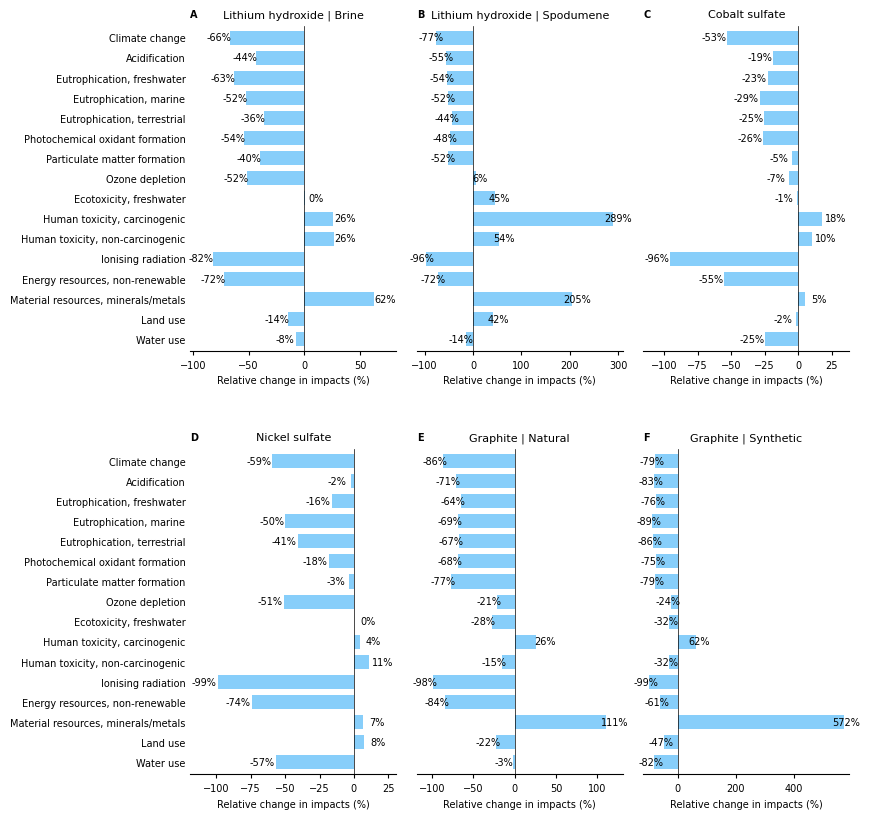

In [69]:
fig, axs = plt.subplots(2, 3, figsize=(fig_length[2]*1.2, fig_height*1), sharey=True)

rm_count = 0
for row in range(2):
    for col in range(3):
        rm_name = mitigation_normalized.index[rm_count]

        # Set titles 
        main_title = list(rm_titles.keys())[rm_count]
        axs[row,col].set_title(main_title, loc='left', x=-0., fontweight='bold', fontsize=fontsize_axs)
        axs[row,col].set_title(rm_titles[main_title], loc='center', fontsize=fontsize_title)

        
        impacts_rm = calculate_relative_diff_impacts(rm_name)
        impacts_rm["Relative diff GLO"].plot.barh(ax=axs[row,col], color="lightskyblue", edgecolor="none", width=0.70, 
                                          fontsize=fontsize_axs, lw=spineline_width, zorder=2, legend=False)
        
        count_impact = 0
        for value in impacts_rm["Relative diff GLO"]:
            axs[row, col].text(value-10 if value <0 else value+10, count_impact, str(round(value)) + '%', ha="center", color="black", va="center", rotation=0, size=fontsize_axs)
            count_impact += 1
        
        axs[row, col].axvline(x=0, ls="-", color="black", lw=0.5)
        axs[row, col].tick_params(axis='y', which='major', direction='out', length=0, labelsize=fontsize_axs)
        axs[row, col].tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
        axs[row, col].set_xlim(min(impacts_rm["Relative diff GLO"])-20, max(impacts_rm["Relative diff GLO"])+20)

        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].spines['top'].set_visible(False)

        axs[row, col].set_ylabel("")
        axs[row, col].set_xlabel('Relative change in impacts (%)', fontsize=fontsize_label)

        rm_count += 1
    axs[row, col].invert_yaxis()

fig.subplots_adjust(wspace=0.1, hspace=0.3)

#plt.savefig(Path(str(r"..\reports") + '/SI_EF_impacts.jpg'), dpi=600, bbox_inches='tight')

## Fig 5: Decoupling GHG emissions - production volumes

In [15]:
decoupling_df

NameError: name 'decoupling_df' is not defined

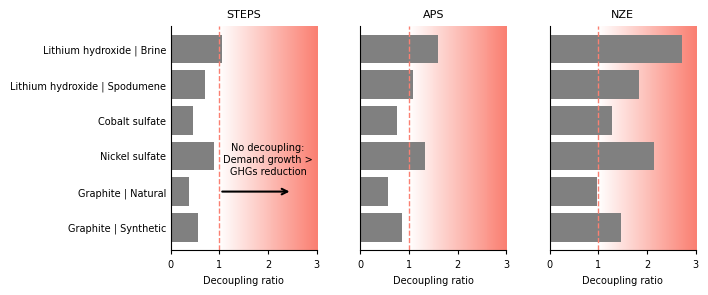

In [23]:
main_title = ["A", "B", "C"]

x_max = 3

fig, axs = plt.subplots(1, 3, figsize=(fig_length[2], fig_height*0.3), sharey=True)

mitigation_for_decoupling = {}
year=2030
count_col = 0
for scenario in ["STEPS", "APS", "NZE"]:
    # Demand data
    total_demand_year = total_demand[(total_demand["Scenario"] == scenario) & (total_demand["Year"] == year)].reset_index()
    ev_demand_year = ev_demand[(ev_demand["Scenario"] == scenario) & (ev_demand["Year"] == year)].reset_index()

    total_demand_increase_rltv = total_demand_year.iloc[:,3:].div(total_demand_2022.iloc[:,3:], axis=0)
    total_demand_increase_rltv = total_demand_increase_rltv.T.sort_values(by=0, ascending=False)

    total_demand_increase_abs = total_demand_year.iloc[:,3:] - total_demand_2022.iloc[:,3:]
    ev_demand_increase_abs = ev_demand_year.iloc[:,3:] - ev_demand_2022.iloc[:,3:]
    demand_increase_by_ev = ev_demand_increase_abs.div(total_demand_increase_abs).T

    demand_times_increase = total_demand_increase_rltv * demand_increase_by_ev

    # GHG emissions data
    decoupling_df = ghgs_times_reduction[["GLOBAL_ELEC"]]
    decoupling_df = decoupling_df.rename(columns={"GLOBAL_ELEC": "GHG emissions reduction"})

    decoupling_df.at["Lithium, brine", "Demand increase"] = demand_times_increase.loc["Lithium"].values
    decoupling_df.at["Lithium, spodumene", "Demand increase"] = demand_times_increase.loc["Lithium"].values
    decoupling_df.at["Cobalt", "Demand increase"] = demand_times_increase.loc["Cobalt"].values
    decoupling_df.at["Nickel", "Demand increase"] = demand_times_increase.loc["Nickel"].values
    decoupling_df.at["Graphite, natural", "Demand increase"] = demand_times_increase.loc["Graphite"].values
    decoupling_df.at["Graphite, synthetic", "Demand increase"] = demand_times_increase.loc["Graphite"].values
    decoupling_df["Decoupling ratio"] = decoupling_df["Demand increase"] / decoupling_df["GHG emissions reduction"]

    axs[count_col].set_title(scenario, loc='center', fontsize=fontsize_title)

    decoupling_df["Decoupling ratio"].plot.barh(ax=axs[count_col], zorder=2, color="grey", width=0.8)
    axs[count_col].invert_yaxis()

    results = (1 - (((1 / decoupling_df['Demand increase']) * actual_mitigation_potential["BAU"]) / actual_mitigation_potential["BAU"])) * 100
    mitigation_for_decoupling[scenario] = results.to_dict()
        
    axs[count_col].axvline(x=1, color='salmon', linestyle='--', lw=1, zorder=2)

    # Create a colormap that starts with white and transitions to salmon
    n_steps = 100
    x = np.linspace(1, x_max, n_steps)
    y1 = np.full_like(x, -1)
    y2 = np.full_like(x, 5)

    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["white", "salmon"])

    for i in range(n_steps):
        axs[count_col].fill_between([x[i], x[i + 1] if i + 1 < n_steps else x_max], -1, 6,
                        color=cmap(i / (n_steps - 1)), alpha=1, zorder=1)
    
    axs[count_col].tick_params(axis='x', which='major', direction='out', length=3, labelsize=fontsize_axs)
    axs[count_col].tick_params(axis='y', which='major', direction='out', length=0, labelsize=fontsize_axs)
    axs[count_col].spines['right'].set_visible(False)
    axs[count_col].spines['top'].set_visible(False)

    axs[count_col].set_xlim(0,x_max)
    axs[count_col].set_xlabel('Decoupling ratio', fontsize=fontsize_label)
    axs[count_col].set_ylabel('')

    fig.subplots_adjust(wspace=0.3, hspace=0.4)
    count_col += 1

axs[0].set_yticklabels(rm_titles.values())

axs[0].annotate('', xy=(2.5, 4), xytext=(1, 4), arrowprops=dict(arrowstyle='->', color='black', linewidth=1.5), annotation_clip=False)
axs[0].text(2, 3.1, "No decoupling:\nDemand growth >\nGHGs reduction", ha="center", va="center", rotation=0, size=7)

plt.savefig(Path(str(r"..\reports") + '/fig5_decoupling.jpg'), dpi=600, bbox_inches='tight')
plt.savefig(Path(str(r"..\reports") + '/Figure 5.pdf'), dpi=600, bbox_inches='tight')

### Table S5: Mitigation for decoupling

In [73]:
mitigation_for_decoupling_df = pd.DataFrame(mitigation_for_decoupling).T.round()

In [76]:
mitigation_for_decoupling_df.T

,STEPS,APS,NZE
"Lithium, brine",68.0,79.0,88.0
"Lithium, spodumene",68.0,79.0,88.0
Cobalt,-3.0,38.0,63.0
Nickel,54.0,69.0,81.0
"Graphite, natural",63.0,76.0,86.0
"Graphite, synthetic",63.0,76.0,86.0


In [86]:
print(88-66, 88-77)
print(63-53)
print(81-59)
print(86-79)

22 11
10
22
7


In [75]:
mitigation_for_decoupling_df.to_csv(DATA_DIR / "results" / f"ESI_mitigation_for_decoupling_{datetime.datetime.today().strftime('%d-%m-%Y')}.csv")